In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import hera_cal
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
Nants = 37

ants = np.loadtxt('antenna_positions_%d.dat'%Nants)
idxs = np.arange(Nants)
antpos = {}
for k,v in zip(idxs,ants):
    antpos[k] = v
    
redbls = hera_cal.redcal.get_pos_reds(antpos)

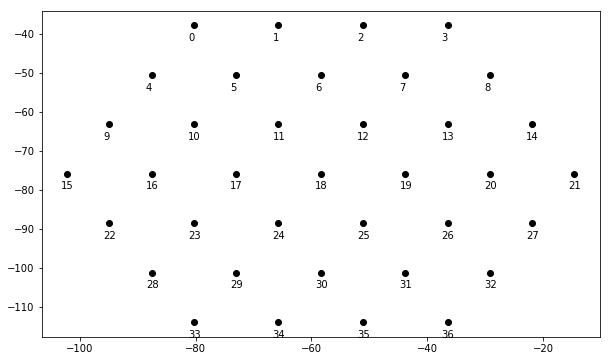

In [6]:
def plot_ants(antpos):
    for k,v in antpos.items():
        plt.plot(v[0],v[1],'ko')
        plt.annotate('%d'%k,xy=(v[0],v[1]),xytext=(v[0]-1,v[1]-4))
plot_ants(antpos)

In [17]:
def plot_redbl(redbls):
    for a1,a2 in redbls:
        plt.plot([antpos[a1][0],antpos[a2][0]],[antpos[a1][1],antpos[a2][1]],'k-')

In [77]:
len(redbls[0])

30

# Minimal inclusion

List of redundant baselines where every antenna is used only once.

**Minimal inclusion will not work because the number of cross correlations you compute is less that the number of equations you need to solve for any redundant pair you consider. **

In [91]:
def ant_in_bls(ant,baselines):
    bl = np.asarray([list(x) for x in baselines])
    if not np.size(bl):
        return False
    if ant in bl[:,0] or ant in bl[:,1]:
        return True
    else: return False
    
def build_minimal_cc(redbl_list):
    minimal_bl = []

    for i,j in redbl_list:
        if ant_in_bls(i,minimal_bl):
            continue
        if ant_in_bls(j,minimal_bl):
            continue
        else: minimal_bl.append((i,j))

    for i,j in redbl_list:
        if not ant_in_bls(i,minimal_bl) or not ant_in_bls(j,minimal_bl):
            minimal_bl.append((i,j))
            
    return minimal_bl

[(5, 0), (6, 1), (7, 2), (8, 3), (10, 4), (16, 9), (18, 11), (19, 12), (20, 13), (21, 14), (22, 15), (24, 17), (29, 23), (31, 25), (32, 26), (33, 28), (35, 30), (27, 20), (34, 29), (36, 31)]


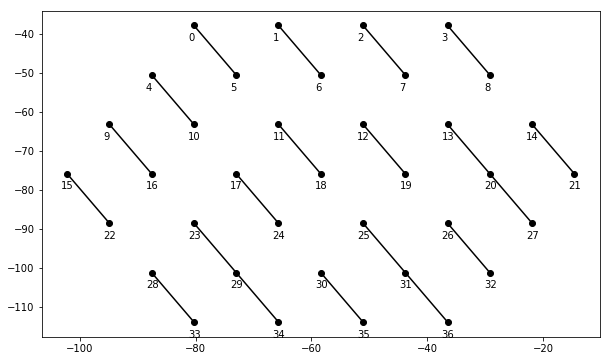

In [96]:
minbl = build_minimal_cc(redbls[0])
plot_ants(antpos)
plot_redbl(minbl)
print minbl

In [97]:
def genA(baseline_list):
    # number of measurements = total number of baselines
    M = len(baseline_list)
    
    # number of parameters = num_ants + num_unique baselines
    N = Nants + 1
    
    A = np.zeros([M,N],dtype=np.complex)
    i = 0
    for bl,reds in enumerate(redbls):
        for pair in reds:
            A[i,pair[0]] = 1+1j
            A[i,pair[1]] = 1-1j
            A[i,Nants+bl] = 1+1j
            i += 1
    return np.matrix(A)

In [98]:
genA(minbl)

40
57


IndexError: invalid index to scalar variable.